Importing libraries

In [1]:
import sys
import random
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

Getting user input

In [3]:
def get_user_input():
    """
    Get and validate user inputs for the quantum circuit parameters.
    """
    try:
        num_qubits = int(input("Enter the number of qubits: "))
        if num_qubits <= 0:
            raise ValueError("Number of qubits must be positive.")
    except ValueError as e:
        print(f"Invalid input for number of qubits: {e}")
        sys.exit(1)

    available_gates = ['h', 'x', 'y', 'z', 'cx', 'ccx']
    print(f"Available gates: {', '.join(available_gates)}")
    selected_gates = input("Enter the gates to include (comma-separated): ").split(',')

    # Validate selected gates
    selected_gates = [gate.strip() for gate in selected_gates]
    for gate in selected_gates:
        if gate not in available_gates:
            print(f"Invalid gate selected: {gate}")
            sys.exit(1)

    try:
        circuit_depth = int(input("Enter the circuit depth (number of layers): "))
        if circuit_depth <= 0:
            raise ValueError("Circuit depth must be positive.")
    except ValueError as e:
        print(f"Invalid input for circuit depth: {e}")
        sys.exit(1)

    gate_application = input("Gate application strategy (random/sequential): ").strip().lower()
    if gate_application not in ['random', 'sequential']:
        print("Invalid gate application strategy. Choose 'random' or 'sequential'.")
        sys.exit(1)

    return num_qubits, selected_gates, circuit_depth, gate_application

Building quantum circuit function

In [4]:
def build_quantum_circuit(num_qubits, selected_gates, circuit_depth, gate_application):
    """
    Build the quantum circuit based on user inputs.
    """
    qc = QuantumCircuit(num_qubits, num_qubits)

    for layer in range(circuit_depth):
        for qubit in range(num_qubits):
            if gate_application == 'random':
                gate = random.choice(selected_gates)
            else:
                gate = selected_gates[layer % len(selected_gates)]

            # Apply the gate
            if gate == 'h':
                qc.h(qubit)
            elif gate == 'x':
                qc.x(qubit)
            elif gate == 'y':
                qc.y(qubit)
            elif gate == 'z':
                qc.z(qubit)
            elif gate == 'cx':
                # Apply CX gate if there are at least 2 qubits
                if num_qubits >= 2:
                    target = (qubit + 1) % num_qubits
                    qc.cx(qubit, target)
            elif gate == 'ccx':
                # Apply CCX gate if there are at least 3 qubits
                if num_qubits >= 3:
                    control1 = qubit
                    control2 = (qubit + 1) % num_qubits
                    target = (qubit + 2) % num_qubits
                    qc.ccx(control1, control2, target)
            else:
                print(f"Unsupported gate encountered: {gate}")
                sys.exit(1)

    # Add measurements
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

Simulating circuit

In [5]:
def simulate_circuit(qc):
    """
    Simulate the quantum circuit and return the results.
    """
    backend = AerSimulator()
    qc_transpiled = transpile(qc, backend)
    job = backend.run(qc_transpiled, shots=1024)
    result = job.result()
    counts = result.get_counts()
    return counts

Main

In [6]:
def main():
    # Get user inputs
    num_qubits, selected_gates, circuit_depth, gate_application = get_user_input()

    # Build the quantum circuit
    qc = build_quantum_circuit(num_qubits, selected_gates, circuit_depth, gate_application)

    # Display the quantum circuit
    print("\nGenerated Quantum Circuit:")
    print(qc.draw(output='text'))

    # Simulate the circuit
    counts = simulate_circuit(qc)

    # Display the results
    print("\nSimulation Results:")
    print(counts)

    # Plot the results
    try:
        plot_histogram(counts)
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting the histogram: {e}")

Executing main

In [ ]:
if __name__ == "__main__":
    main()

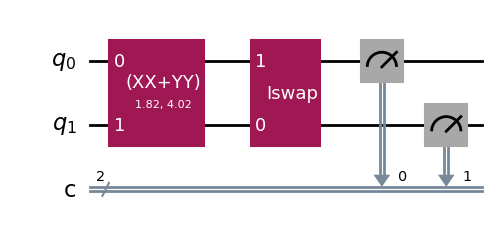

In [7]:
from qiskit.circuit.random import random_circuit
 
circ = random_circuit(2, 2, measure=True)
circ.draw(output='mpl')

In [ ]:
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

# Get the noise model of ibmq_lima
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_lima = provider.get_backend('ibmq_lima')
noise_model = NoiseModel.from_backend(backend_lima)

# Get coupling map from backend
coupling_map = backend_lima.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)